# Training the kmeans model

### 1. Load the data and libraries

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns




In [19]:
df = pd.read_csv('../data/7_Bru_one_hot_encoded_is_hot_cleaned_numerical.csv')
df.head()

,release_date,popularity,duration_ms,explicit,childrens music,jackin house,mans orchestra,punk n roll,womens music,21st century classical,...,ye ye,yodeling,zarzuela,zilizopendwa,zolo,zouglou,zouk,zouk riddim,zydeco,is_hot
0,2008,14,150040,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2004,1,253000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,3,240400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2007,1,138760,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,0,199986,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Create new columns for genres.

In [20]:
# Load the data
df = pd.read_csv('../data/7_Bru_one_hot_encoded_is_hot_cleaned_numerical.csv')
print("Original shape:", df.shape)

# Keep initial columns we want
initial_columns = ['release_date', 'popularity', 'duration_ms', 'explicit']
final_df = df[initial_columns].copy()

# Define the genre keywords
genre_keywords = ['rock', 'pop', 'jazz', 'hiphop', 'electronic', 'classical', 'blues', 'indie']

# Get all columns except the basic info columns
genre_columns = df.columns[4:-1]  # Excluding the first 4 columns and is_hot column

# Process each genre keyword
for genre in genre_keywords:
    # Find all columns containing this genre
    matching_columns = [col for col in genre_columns if genre.lower() in col.lower()]
    
    if matching_columns:
        # Combine all matching columns using OR operation
        final_df[f'is_{genre}'] = df[matching_columns].any(axis=1).astype(int)
        print(f"Found {len(matching_columns)} columns for {genre}")
    else:
        print(f"No columns found for {genre}")

# Add is_hot column
final_df['is_hot'] = df['is_hot']

# Print results
print("\nColumns in final dataset:", final_df.columns.tolist())
print("Final shape:", final_df.shape)

# Show the distribution of genres
genre_cols = [col for col in final_df.columns if col.startswith('is_')]
genre_dist = final_df[genre_cols].sum().sort_values(ascending=False)

print("\nGenre distribution:")
for genre, count in genre_dist.items():
    print(f"{genre}: {count} tracks")

# Show sample of the processed data
print("\nSample of processed data:")
final_df.head()

# Save the processed dataset
final_df.to_csv('../data/processed_spotify_data.csv', index=False)
print("\nProcessed data saved to 'processed_spotify_data.csv'")

Original shape: (5060, 1537)
Found 138 columns for rock
Found 143 columns for pop
Found 66 columns for jazz
No columns found for hiphop
Found 15 columns for electronic
Found 24 columns for classical
Found 35 columns for blues
Found 77 columns for indie

Columns in final dataset: ['release_date', 'popularity', 'duration_ms', 'explicit', 'is_rock', 'is_pop', 'is_jazz', 'is_electronic', 'is_classical', 'is_blues', 'is_indie', 'is_hot']
Final shape: (5060, 12)

Genre distribution:
is_rock: 1198 tracks
is_pop: 881 tracks
is_blues: 352 tracks
is_jazz: 266 tracks
is_indie: 159 tracks
is_classical: 77 tracks
is_electronic: 70 tracks
is_hot: 12 tracks

Sample of processed data:

Processed data saved to 'processed_spotify_data.csv'


## 3. Check and clean the data

In [4]:
final_df.shape

(5060, 12)

In [5]:
final_df.isnull().sum()

release_date     0
popularity       0
duration_ms      0
explicit         0
is_rock          0
is_pop           0
is_jazz          0
is_electronic    0
is_classical     0
is_blues         0
is_indie         0
is_hot           0
dtype: int64

In [6]:
final_df.duplicated().sum()

np.int64(66)

In [7]:
final_df.drop_duplicates(inplace=True)

## 4. Scale the data

In [13]:

features = final_df.drop(columns=['is_hot'])

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)


scaled_df = pd.DataFrame(scaled_features, columns=features.columns)


scaled_df.head()


,release_date,popularity,duration_ms,explicit,is_rock,is_pop,is_jazz,is_electronic,is_classical,is_blues,is_indie
0,0.587416,0.093278,-0.809204,-0.260343,1.800831,2.184814,-0.235777,-0.117492,-0.123479,-0.274107,-0.180161
1,0.294668,-0.716533,0.161462,-0.260343,-0.555299,2.184814,-0.235777,-0.117492,-0.123479,-0.274107,-0.180161
2,0.806978,-0.591947,0.042674,-0.260343,-0.555299,-0.457705,-0.235777,-0.117492,-0.123479,-0.274107,-0.180161
3,0.514229,-0.716533,-0.915547,3.841086,-0.555299,-0.457705,-0.235777,-0.117492,-0.123479,-0.274107,5.550578
4,1.612036,-0.778826,-0.338333,-0.260343,-0.555299,2.184814,-0.235777,-0.117492,-0.123479,-0.274107,-0.180161


## 5. Train the model

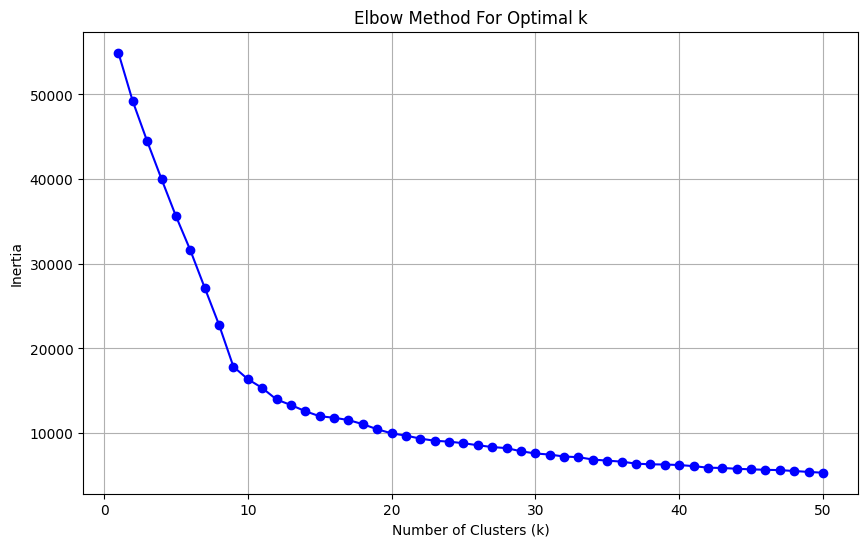

In [14]:
inertia_values = []

# Iterate over k values from 1 to 50
for k in range(1, 51):
    # Initialize the KMeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the KMeans model to the scaled data
    kmeans.fit(scaled_df)
    
    # Append the inertia value (sum of squared distances to the closest cluster center) for this k
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

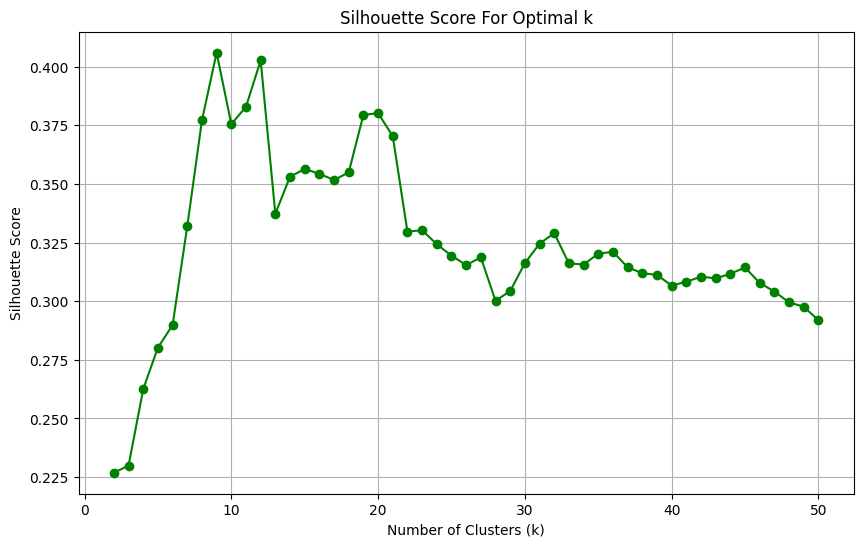

In [15]:


# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate over k values from 2 to 50 (Silhouette Score is undefined for k=1)
for k in range(2, 51):
    # Initialize the KMeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the KMeans model to the scaled data
    kmeans.fit(scaled_df)
    
    # Calculate the silhouette score for the current k
    score = silhouette_score(scaled_df, kmeans.labels_)
    
    # Append the silhouette score for this k
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 51), silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


### Based on the elbow and silhouette score, the optimal k is 9. At the next step, we will train the model with k=9 and save the model and the scaler for the streamlit app.


## 6. Save the model and the scaler


In [16]:
import joblib

# Initialize the KMeans model with k=10
optimal_k = 9
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the model to your scaled data
kmeans_model.fit(scaled_df)

# Save the trained KMeans model to a .pkl file
joblib.dump(kmeans_model, 'kmeans_model_9.pkl')

print("Model saved as 'kmeans_model_9.pkl'.")

Model saved as 'kmeans_model_9.pkl'.


In [17]:
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'.")

Scaler saved as 'scaler.pkl'.
